In [29]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.time import Time
import astropy.stats as stats
from datetime import datetime, timedelta

In [30]:
def readfile(filename):
    with open(filename, 'r') as fin:
        # human readable string for information
        comment = fin.readline()
        # timestamps [channel velocities]
        header = fin.readline()
        data = fin.readlines()

    chan_vel = np.array(header.strip().split(',')[1:-1], dtype=float)

    for cntr, line in enumerate(data):
        if cntr < 1:
            file_data = np.array(line.strip().split(',')[:-1], dtype=float)
        else:
            file_data = np.vstack([file_data, np.array(line.strip().split(',')[:-1], dtype=float)])

    timestamps = file_data[:,0]
    spectra = file_data[:,1:]
    
    return [chan_vel, timestamps, spectra]

In [31]:
def ts2datetime(timestamps, epoch=0., tsformat='mjd'):
    return Time(timestamps + epoch, format=tsformat)

In [32]:
filename = 'vmic.tscatJD'
[chan_vel, timestamps, spectra] = readfile(filename)
ts_jd = ts2datetime(timestamps)
channel = 3  # (15 is the other channel)
chan_data = spectra[:, channel]

Text(0.5,0,'Timestamp')

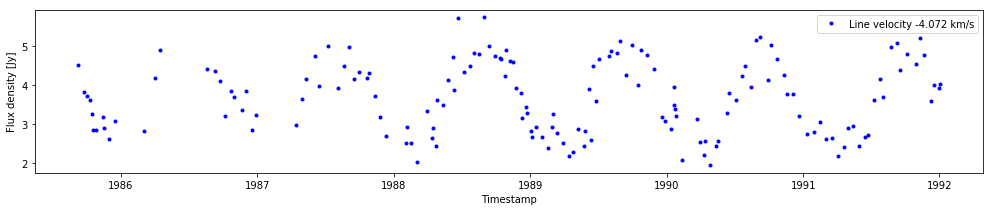

In [33]:
fig= plt.subplots(figsize=(17,3),
                  facecolor='white')
ax = plt.subplot(111)
ax.plot(ts_jd.datetime,
        chan_data,
        'b.',
        label=r'Line velocity {} km/s'.format(chan_vel[channel]))
ax.legend(loc=0)
ax.set_ylabel('Flux density [Jy]')
ax.set_xlabel('Timestamp')

Don't auto-clean the data, only manually remove known bad data points.

The data is clearly periodic, the noise from outliers will not affect the period detection significantly. Accidental removal of real data point that may look like outliers may affect the calculation.

### Compute the periodogram
Find the best period in days

In [34]:
ls = stats.LombScargle(ts_jd.value, chan_data - chan_data.mean())
frequency, power = ls.autopower()
period = 1./frequency # period is the inverse of frequency
best_period = 1./frequency[np.argmax(power)]  # period with most power / strongest signal
best_freq = frequency[np.argmax(power)]

Text(0.03,0.93,'period = 378.450 days')

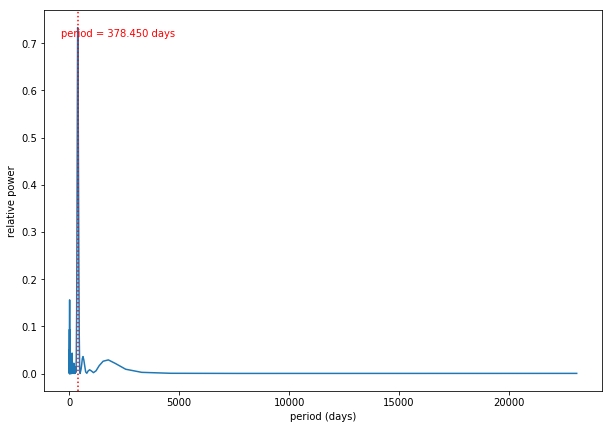

In [35]:
fig= plt.subplots(figsize=(10,7),
                  facecolor='white')
ax = plt.subplot(111)
ax.plot(period,power)
ax.axvline(best_period, color='r',linestyle=':');
ax.set_xlabel('period (days)')
ax.set_ylabel('relative power')
ax.text(0.03,0.93,'period = {:.3f} days'.format(best_period),transform=ax.transAxes,color='r')

In [36]:
def get_folded_phase(t, best_period):
    """Fold the observation times with the best period of the variable signal."""
    # light curve over period, take the remainder (i.e. the "phase" of one period)
    phase = (t / best_period) % 1
    return phase

In [37]:
# compute model fitted values
phase_fit = np.linspace(0., 1.)
mag_fit = stats.LombScargle(
            ts_jd.value, chan_data - chan_data.mean()).model(
                t=phase_fit / best_freq, frequency=best_freq)

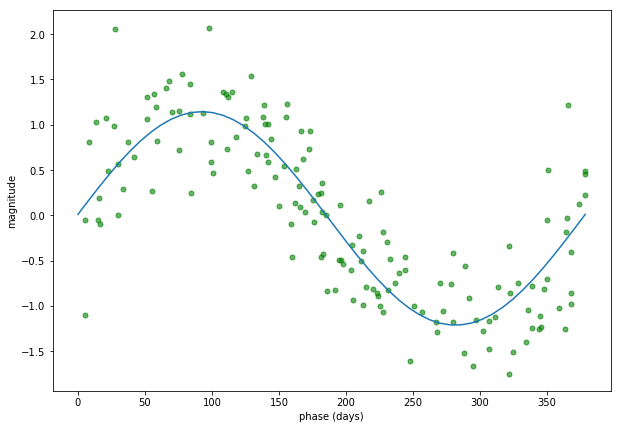

In [38]:
# Plot folded lightcurve
phase = get_folded_phase(ts_jd.value, best_period)
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(best_period*phase, chan_data - chan_data.mean(),
        marker='.',
        ms=10,
        ls='none',
        lw=1,
        color='g',
        alpha=0.6)
ax.plot(best_period*phase_fit, mag_fit)
ax.set_xlabel('phase (days)')
ax.set_ylabel('magnitude');

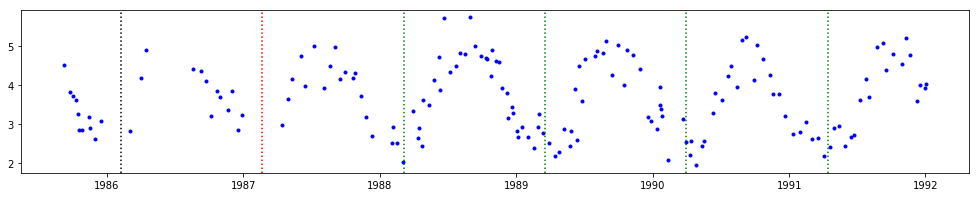

In [39]:
fig= plt.subplots(figsize=(17,3),
                  facecolor='white')
ax = plt.subplot(111)
ax.plot(ts_jd.datetime, chan_data, 'b.')

# get date to start the periodic cycle
tick1 = ts_jd.datetime[24] - ts_jd.datetime[23]
date = ts_jd.datetime[23] + tick1/2
ax.axvline(x=date, color='r', linestyle=':')

# add best period to start date
for cntr in range(4):
    date += timedelta(days=best_period)
    ax.axvline(x=date, color='g', linestyle=':')

# subtract best period to get indication of possible date in sparse initial measurements
date = ts_jd.datetime[23] + tick1/2 - timedelta(days=best_period)
ax.axvline(x=date, color='k', linestyle=':')